# <center>How Does Curricular Complexity Affect Time-to-Degree?</center>
## <center> Study Design </center>


## Introduction
The following Julia programming language packages will be used in the analyses provided in this notebook:

In [617]:
using CurricularAnalytics, CurricularVisualization
using DataFrames
using GLM
using StatsBase
using Plots
using CSV
using LaTeXStrings

The first portion of this study invoves determining the impact of a program's curricular complexity on a student's ability to graduate from that program within 4, 5, and 6 years. This portion of the study does *not* take into account student or institutional characteristics. This portion of the work will set the baseline for determing how additional factors influence the aforementioned gradution rates. Thus, if $X$ denotes the curricular (structural) complexity of a particular academic program, we'd like to determine its causal affect on the program's graduation rate, which can be represented as a causal diagram:
![XY](./XY-causal.pdf)
which should be read as "$X$ has a causal impact on $Y$."  The variable $U$ shown in this figure is meant to model unknown influences on the graduation rates (e.g., background preparation, motivation, etc.), and we will elaborate them in subsequent work.

There are likely many other "confounding" factors that impact a student's ability to graduate within a given timeframe. These will be considered in the sequel, as we build upon the initial causal model shown above.

### Logistic Regression Model
Next we demonstrate how to construct a logistic regression model that can be used to study how program curricular complexity affects a student's ability to graduate from that program within 4, 5, and 6 years.

We will model the problem using regression techniques, with the dependent variable being whether or not a student graduated within a particular timeframe, and the independent variable being the curricular (i.e., structural) complexity. Later we will include other independent variables related to student demographics and instructional complexity. Because the dependent variables are dichotomous, i.e., a student either graduates or not within a given time period, we will apply *logistic regression* in order to deal with this nonlinearity.  

Consider first the relationship between program curricular complexity and the probability that a student will be able to graduate from that program within four years. We will use $Y=1$ is a binary outcome variable that indicates a student was able to gradaute within four years, and $Y=0$ to denote a student was *not* able to graduate within fours.  Thus, we are interested in using previously collected student data to estimate:
$$
   \mbox{Prob}\{Y | X\}. 
$$

Logistic regression is commonly used to create a model for "explaining" how variances in binary dependent variables relate to changes in the independent variables. Logistic regression makes use of the logistic function, expressed as: 
$$ 
\begin{equation}
 \mbox{Prob}\{Y=1| X\} = \left[1 + e^{-(b_0 + b_1X)}\right]^{-1}.
 \label{logistic}
\end{equation}
$$
A graph of the function 
$$
 P = \left[1 + e^{-x}\right]^{-1}
$$
is shown in the figure below.

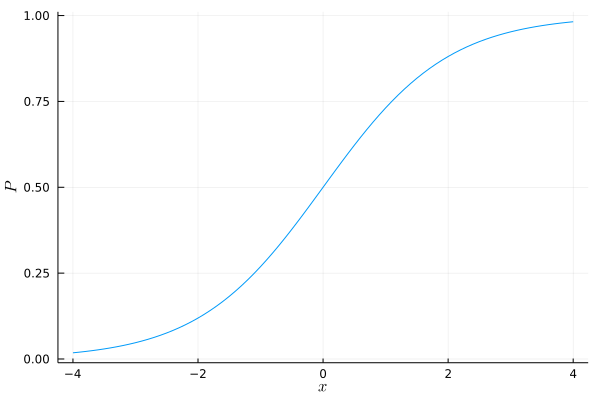

In [595]:
X = [i*0.1 for i in -40:40]
Y = [1/(1+exp(-x)) for x in X]
plot(X, Y, seriestype = :line, xlabel = latexstring("x"), ylabel=latexstring("P"), legend=false)

Notice that this transformation maps any $x$ value in $(-\infty, \infty)$ to a $P$ value in $[0,1]$.  Notice also that there is a region of $x$, from about -1.5 to 1.5, that is roughly linear, and where a small change in $x$ yields a large change in $P$.  This is also the behavior we see on test data when we compare compare graduation rates to curricular complexity.  That is, there is a linear region, of intermediate curricular complexities values, where small changes in curricular complexity yeild large changes in student success (i.e., graduation rates), but at very low and very high curricular complexity values, small changes in curricular complexity produce small changes in student success. At the extremes, almost everyone graduates within four years (low curricular complexity) or almost nobody graduates within four years (high curricular complexity).

Solving the logistic function for $x$ yields the inverse logistic function, also know as the logistic transformation (or *logit* for short). Specifically,
$$ 
 \begin{eqnarray}
 \ln P & = & \ln\left({1 \over 1 + e^{-x}}\right) = \ln\left({e^x \over 1 + e^{x}}\right) \\
       & = & \ln e^x - \ln(1 + e^x) \\
       & = & x + \ln\left({1 \over 1 + e^{x}}\right) \\
       & = & x - \ln(1-P)
 \end{eqnarray}
$$
and therefore
$$
  x = \ln\left({P \over 1-P}\right).
$$

This logit equation has an interesting, and important, interpretation. Specifically, if we treat $P_i$ as the probability of an event $i$ occuring, then the quantity $P_i/(1-P_i)$ corresponds to the *odds* of an event $i$ occuring, and the *logged odds* for that event is defined as:
$$
   L_i = \log \left[{P_i \over 1-P_i} \right].
$$

The purpose of logistic regression is to estimate the $P_i$ values (i.e., the probability of graduating within a given timeframe) from observed data. This is accomplished by determing the $b_0$ and $b_1$ coefficients in the logistic equation provided above through maximum likelihood estimation. 

### Data Requirements
The data that will be used to estimate these coefficients should be collected as follows. First, the analysis is backwards looking, which means the cohort should be defined as follows: Start with everyone who graduated in a given term, and then look backwards to see which first-time full-time (FTFT) cohort they belonged to. If they don’t belong to a FTFT cohort, they should be excluded from the data (i.e., the analysis should focus on full-time students).  From this you should compute how many years it took each student to graduate.  

A sample spreadsheet with the required fields is supplied with this notebook. This spreadsheet contains the following data fields (columns):

- program_code: a short-hand (unique) code used to refer to the program. This may be used in visualizations. 
- program_name: the acutal name of the program. 
- complexity_score: computed from supplied curricular data
- total_degrees_awarded: total number of graduates from the program over the terms considered.
- less_than_four: count of those in the cohort who graduated in less than four years
- four: count of those in the cohort who graduated within four years (this includes the less_than_four students)
- four_and_half: count of those in the cohort who graduated within four-and-one-half years
- five: count of those in the cohort who graduated within five years
- five_and_half: count of those in the cohort who graduated within five-and-one-half years
- six: count of those in the cohort who graduated within six  

**A Note on Sample Size.**
It is important to collect a sufficient amount of data in order to obtain accurate estimates of the coefficietns. A discussion of sufficient sample size statistics is beyond the scope of this notebook, but as a rule of thumb, the goal should be to collect on the order of thousands of samples across a large range of programs with different curricular complexity values. In practice this typically involves collecting 6-10 terms worth of graduation data across all of the undergradaute programs at a given institution.

For a semester-based institution, 6-10 terms corresponds to 3-5 years worth of data.  Given that programs often change their requirements over time, this introduces the problem of a program's curricular compleixty possibly changing over the data collection period. Rather than trying to track which students graduated from particular versions of a program, it may be easiest to simply average the curricular complexity scores of a program over time, and treat this as a small amount of noise in the data.

### Example
Graduation data over the past four years (2016-2020) was collected from the University of Arizona.  All undergraduate programs at the university currently in existance are included in this data set.  In order to work with this data set, we will read them into a data frame.

In [602]:
df = DataFrame(CSV.File("./Complexity_x_Grad_UA.csv"));
showall(df)

307×13 DataFrame
│ Row │ program_code │ program_name                   │ sub-plan_code │
│     │ String       │ String                         │ String        │
├─────┼──────────────┼────────────────────────────────┼───────────────┤
│ 1   │ BNADBSBA     │ Business Administration        │ -             │
│ 2   │ BIOINBS      │ Bioinformatics                 │ CSCI          │
│ 3   │ LAWBA        │ Law                            │ -             │
│ 4   │ SYEBSSYE     │ Systems Engineering            │ -             │
│ 5   │ GNSBGS       │ General Studies                │ AMENT         │
│ 6   │ ECEBSECE     │ Electrical & Computer Engineer │ -             │
│ 7   │ ENGLBA       │ English                        │ -             │
│ 8   │ GEOSBS       │ Geosciences                    │ GEO           │
│ 9   │ PHILBA       │ Philosophy                     │ ETHICS        │
│ 10  │ RCSCBS       │ Retailing & Consumer Science   │ -             │
│ 11  │ PHLBS        │ Public Health           

│ 185 │ GNSBGS       │ General Studies                │ SBHU          │
│ 186 │ CHEBSCHE     │ Chemical Engineering           │ -             │
│ 187 │ NURSBSN      │ Nursing                        │ CONV          │
│ 188 │ CLASBA       │ Classics                       │ CCV           │
│ 189 │ MEEBSMEE     │ Mechanical Engineering         │ -             │
│ 190 │ GWSBA        │ Gender & Women's Studies       │ -             │
│ 191 │ GNSTBGS      │ General Studies                │ SBHHU         │
│ 192 │ PHYSBS       │ Physics                        │ -             │
│ 193 │ PHLBS        │ Public Health                  │ HLPROMO       │
│ 194 │ SLHSBS       │ Speech, Language & Hearing Sci │ -             │
│ 195 │ BEBSBE       │ Biosystems Engineering         │ -             │
│ 196 │ ABEMBS       │ Agribusiness Economics & Mgmt  │ ABEMMAN       │
│ 197 │ LASBA        │ Latin American Studies         │ -             │
│ 198 │ ISABA        │ Information Science & Arts     │ -       

│ 81  │ Law Enforcement Intelligence   │ 43               │
│ 82  │ Systems and Big Data Biology   │ 148              │
│ 83  │ Musicology, Ethnomus & Theory  │ 131              │
│ 84  │ Organizational Leadership      │ 57               │
│ 85  │ Not Available                  │ 40               │
│ 86  │ Not Available                  │ 76               │
│ 87  │ Not Available                  │ 73               │
│ 88  │ Informatics                    │ 53               │
│ 89  │ General                        │ 60               │
│ 90  │ Not Available                  │ 126              │
│ 91  │ Not Available                  │ 49               │
│ 92  │ Not Available                  │ 68               │
│ 93  │ Not Available                  │ 42               │
│ 94  │ Not Available                  │ 82               │
│ 95  │ Design Technical Production    │ 52               │
│ 96  │ Visual Communication           │ 43               │
│ 97  │ Not Available                  │

│ 5   │ 67                    │ 6           │ 40    │ 49              │ 53    │
│ 6   │ 307                   │ 12          │ 197   │ 228             │ 267   │
│ 7   │ 92                    │ 24          │ 70    │ 76              │ 81    │
│ 8   │ 74                    │ 6           │ 53    │ 61              │ 64    │
│ 9   │ 26                    │ 6           │ 10    │ 12              │ 14    │
│ 10  │ 345                   │ 29          │ 234   │ 291             │ 327   │
│ 11  │ 44                    │ 7           │ 31    │ 38              │ 41    │
│ 12  │ 2                     │ 0           │ 1     │ 1               │ 1     │
│ 13  │ 32                    │ 9           │ 25    │ 25              │ 25    │
│ 14  │ 15                    │ 1           │ 8     │ 9               │ 10    │
│ 15  │ 45                    │ 1           │ 30    │ 35              │ 38    │
│ 16  │ 237                   │ 14          │ 132   │ 210             │ 219   │
│ 17  │ 1                     │ 0       

│ 195 │ 49                    │ 1           │ 20    │ 32              │ 44    │
│ 196 │ 26                    │ 2           │ 12    │ 18              │ 22    │
│ 197 │ 7                     │ 3           │ 6     │ 6               │ 6     │
│ 198 │ 48                    │ 4           │ 29    │ 35              │ 42    │
│ 199 │ 35                    │ 5           │ 23    │ 24              │ 27    │
│ 200 │ 2                     │ 0           │ 0     │ 0               │ 1     │
│ 201 │ 131                   │ 16          │ 116   │ 120             │ 126   │
│ 202 │ 15                    │ 3           │ 14    │ 14              │ 14    │
│ 203 │ 71                    │ 16          │ 56    │ 62              │ 68    │
│ 204 │ 7                     │ 1           │ 3     │ 4               │ 5     │
│ 205 │ 6                     │ 0           │ 5     │ 5               │ 5     │
│ 206 │ 6                     │ 0           │ 1     │ 1               │ 4     │
│ 207 │ 1                     │ 0       

│ 117 │ 16              │ 16    │ 0              │
│ 118 │ 3               │ 3     │ 0              │
│ 119 │ 3               │ 3     │ 0              │
│ 120 │ 6               │ 6     │ 0              │
│ 121 │ 2               │ 2     │ 0              │
│ 122 │ 7               │ 7     │ 0              │
│ 123 │ 4               │ 4     │ 6              │
│ 124 │ 3               │ 3     │ 4              │
│ 125 │ 85              │ 85    │ 1              │
│ 126 │ 523             │ 524   │ 3              │
│ 127 │ 36              │ 36    │ 3              │
│ 128 │ 167             │ 168   │ 9              │
│ 129 │ 3               │ 3     │ 2              │
│ 130 │ 8               │ 9     │ 2              │
│ 131 │ 7               │ 7     │ 4              │
│ 132 │ 7               │ 7     │ 1              │
│ 133 │ 23              │ 26    │ 3              │
│ 134 │ 69              │ 72    │ 4              │
│ 135 │ 92              │ 94    │ 6              │
│ 136 │ 0               │ 0    

│ 279 │ 23              │ 26    │ 4              │
│ 280 │ 4               │ 4     │ 1              │
│ 281 │ 0               │ 0     │ 1              │
│ 282 │ 54              │ 56    │ 0              │
│ 283 │ 7               │ 8     │ 0              │
│ 284 │ 9               │ 10    │ 1              │
│ 285 │ 95              │ 96    │ 2              │
│ 286 │ 7               │ 7     │ 2              │
│ 287 │ 298             │ 302   │ 7              │
│ 288 │ 3               │ 3     │ 1              │
│ 289 │ 42              │ 42    │ 1              │
│ 290 │ 2               │ 2     │ 1              │
│ 291 │ 6               │ 6     │ 1              │
│ 292 │ 9               │ 9     │ 0              │
│ 293 │ 1               │ 1     │ 0              │
│ 294 │ 9               │ 9     │ 0              │
│ 295 │ 1               │ 1     │ 0              │
│ 296 │ 4               │ 4     │ 0              │
│ 297 │ 9               │ 9     │ 0              │
│ 298 │ 9               │ 10   

Complexity distrubtion of the undergraduate programs at the Unviersity of Arizona

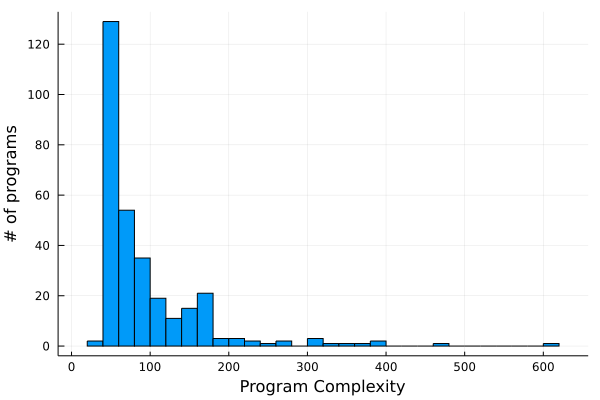

In [624]:
histogram(df.complexity_score, nbins=50, xlabel="Program Complexity", ylabel="# of programs", label="")

Next we extract the information we need from this data set in order to perform logistic regression and we place it into a new data frame containing one entry per student considered in the original data set:

In [605]:
X = Array{Integer,1}() # curricular complexity score of program
Y = Array{Bool,1}() # did student graduate within 4 years?
Z = Array{Bool,1}() # did student graduate within 6 years?
for row in eachrow(df)
  for t in 1:row["four"] 
    push!(X, row["complexity_score"])
    push!(Y, 1); push!(Z, 1)
  end
  s = row["total_degrees_awarded"] - row["six"]
  for t in 1:(row["total_degrees_awarded"] - row["four"])
    push!(X, row["complexity_score"])
    push!(Y, 0)
    s > 0 ? (push!(Z, 1); s=s-1) : push!(Z, 0)
  end
end
df_binary = DataFrame(Program_Complexity = X, grad4 = Y, grad6 = Z);

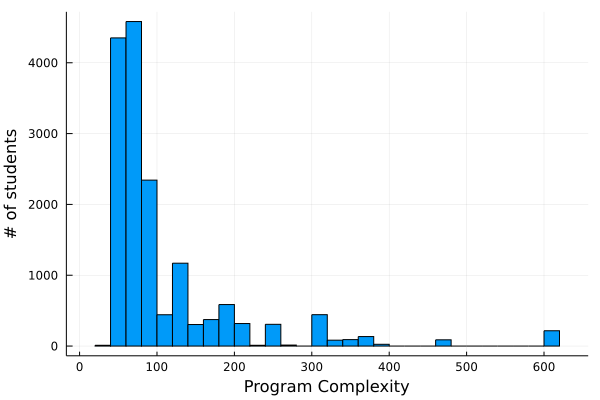

In [625]:
histogram(X, nbins=50, xlabel="Program Complexity", ylabel="# of students", label="")

Then, we peform the logistic regression using this data frame:

In [626]:
logit4 = glm(@formula(grad4 ~ Program_Complexity), df_binary, Binomial(), LogitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, LogitLink}, GLM.DensePredChol{Float64, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}}}, Matrix{Float64}}

grad4 ~ 1 + Program_Complexity

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────
                          Coef.   Std. Error      z  Pr(>|z|)    Lower 95%     Upper 95%
────────────────────────────────────────────────────────────────────────────────────────
(Intercept)          1.0632      0.0262812    40.45    <1e-99   1.01169      1.11471
Program_Complexity  -0.00115154  0.000173629  -6.63    <1e-10  -0.00149185  -0.000811233
────────────────────────────────────────────────────────────────────────────────────────

In [627]:
logit6 = glm(@formula(grad6 ~ Program_Complexity), df_binary, Binomial(), LogitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, LogitLink}, GLM.DensePredChol{Float64, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}}}, Matrix{Float64}}

grad6 ~ 1 + Program_Complexity

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────
                          Coef.   Std. Error      z  Pr(>|z|)    Lower 95%    Upper 95%
───────────────────────────────────────────────────────────────────────────────────────
(Intercept)          1.38573     0.0281111    49.29    <1e-99   1.33063      1.44083
Program_Complexity  -0.00140523  0.000180759  -7.77    <1e-14  -0.00175951  -0.00105095
───────────────────────────────────────────────────────────────────────────────────────

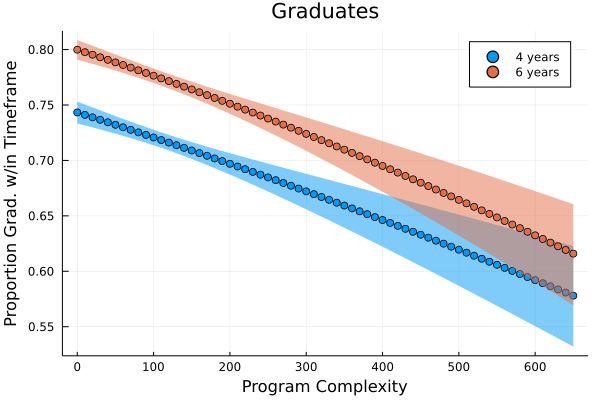

In [628]:
CC_scores = DataFrame(Program_Complexity = 0:10:650)
pred4 = predict(logit4, CC_scores, interval = :confidence)
pred6 = predict(logit6, CC_scores, interval = :confidence)
plot(xlabel="Program Complexity", ylabel="Proportion Grad. w/in Timeframe", title="Graduates")
plot!(CC_scores.Program_Complexity, pred4.prediction , seriestype = :scatter, labels="4 years",
       ribbon = (pred4.prediction .- pred4.lower, pred4.upper .- pred4.prediction))
plot!(CC_scores.Program_Complexity, pred6.prediction , seriestype = :scatter, labels="6 years",
       ribbon = (pred6.prediction .- pred6.lower, pred6.upper .- pred6.prediction))

In [629]:
probit4 = glm(@formula(grad4 ~ Program_Complexity), df_binary, Binomial(), ProbitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, ProbitLink}, GLM.DensePredChol{Float64, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}}}, Matrix{Float64}}

grad4 ~ 1 + Program_Complexity

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────
                          Coef.   Std. Error      z  Pr(>|z|)    Lower 95%     Upper 95%
────────────────────────────────────────────────────────────────────────────────────────
(Intercept)          0.654872    0.0158034    41.44    <1e-99   0.623898     0.685846
Program_Complexity  -0.00070069  0.000106431  -6.58    <1e-10  -0.00090929  -0.000492089
────────────────────────────────────────────────────────────────────────────────────────

In [581]:
probit6 = glm(@formula(grad6 ~ Program_Complexity), df_binary, Binomial(), ProbitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, ProbitLink}, GLM.DensePredChol{Float64, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}}}, Matrix{Float64}}

grad6 ~ 1 + Program_Complexity

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────
                           Coef.   Std. Error      z  Pr(>|z|)    Lower 95%    Upper 95%
────────────────────────────────────────────────────────────────────────────────────────
(Intercept)          0.844203     0.0164467    51.33    <1e-99   0.811968     0.876438
Program_Complexity  -0.000841272  0.000108972  -7.72    <1e-13  -0.00105485  -0.00062769
────────────────────────────────────────────────────────────────────────────────────────

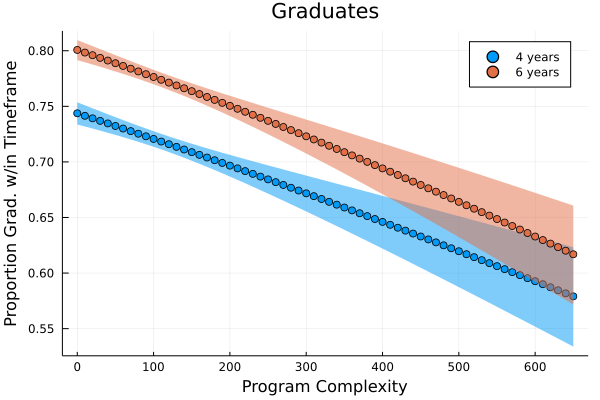

In [603]:
CC_scores = DataFrame(Program_Complexity = 0:10:650)
pred4 = predict(probit4, CC_scores, interval = :confidence)
pred6 = predict(probit6, CC_scores, interval = :confidence)
plot(ç title="Graduates")
plot!(CC_scores.Program_Complexity, pred4.prediction , seriestype = :scatter, labels="4 years",
       ribbon = (pred4.prediction .- pred4.lower, pred4.upper .- pred4.prediction))
plot!(CC_scores.Program_Complexity, pred6.prediction , seriestype = :scatter, labels="6 years",
       ribbon = (pred6.prediction .- pred6.lower, pred6.upper .- pred6.prediction))

## References

Heileman, G. L., Abdallah, C.T., Slim, A., and Hickman, M. (2018). Curricular analytics: A framework for quantifying the impact of curricular reforms and pedagogical innovations. www.arXiv.org, arXiv:1811.09676 [cs.CY].

